In [ ]:
!python -V

Python 3.12.4


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlexp.db")
mlflow.set_experiment("nyctaxi-experiment")

<Experiment: artifact_location='file:///d:/ML/zoomcamp/02-Experiment-tracking/mlruns/1', creation_time=1740471480731, experiment_id='1', last_update_time=1740471480731, lifecycle_stage='active', name='nyctaxi-experiment', tags={}>

In [7]:
df_full = pd.read_parquet('./data/yellow_tripdata_2024-01.parquet')
df = df_full.sample(frac=0.2,random_state=42)

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.939664563432414

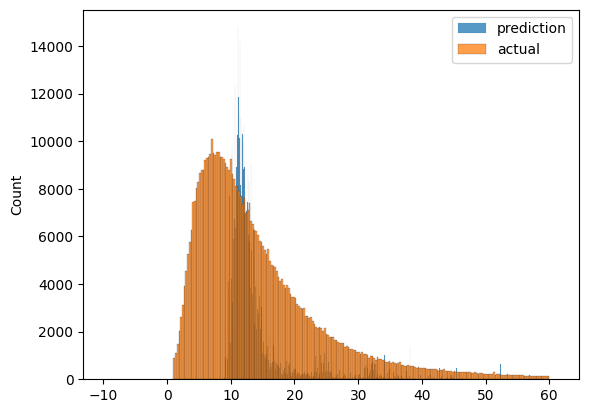

In [9]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df_full = pd.read_csv(filename)
        df = df_full.sample(frac=0.2,random_state=42)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df_full = pd.read_parquet(filename)
        df = df_full.sample(frac=0.2,random_state=42)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/yellow_tripdata_2024-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2024-02.parquet')

In [13]:
len(df_train), len(df_val)

(579995, 587734)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

5.586996911195517

In [45]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [17]:
with mlflow.start_run():
    mlflow.set_tag("developer","Pravir")
    mlflow.log_param("train-data-path","./data/yellow_tripdata_2024-01.parquet")
    mlflow.log_param("valid-data-path","./data/yellow_tripdata_2024-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

In [20]:
import xgboost as xgb

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [22]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [24]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=3,
            evals=[(valid, 'validation')]
            ##early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': 40, ## scope.int(hp.quniform('max_depth', 40, 100, 10)),
    'learning_rate': 0.3, ## hp.loguniform('learning_rate', -3, 0),
    ##'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    ##'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    ##'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    ##max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:8.21382                                            
[1]	validation-rmse:6.96485                                            
[2]	validation-rmse:6.23847                                            
[0]	validation-rmse:8.21382                                                                                       
[1]	validation-rmse:6.96485                                                                                       
[2]	validation-rmse:6.23847                                                                                       
[0]	validation-rmse:8.21382                                                                                       
[1]	validation-rmse:6.96485                                                                                       
[2]	validation-rmse:6.23847                                                                                       
[0]	validation-rmse:8.21382                                                                   

In [30]:
mlflow.xgboost.autolog(disable=True)

In [31]:
with mlflow.start_run():

    best_params = {'learning_rate' : 0.22212348254036549,
                    'max_depth': 56,
                    'objective': 'reg:linear',
                    'reg_alpha': 0.35033192932716933,
                    'reg_lamba': 0.15536482752478878,
                    'seed': 42 }
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=10,
                evals=[(valid, 'validation')]
                ##early_stopping_rounds=50
            )
    y_pred  = booster.predict(valid)
    rmse = root_mean_squared_error(y_val,y_pred)
    mlflow.log_metric('rmse',rmse)

    with open('models/preprocessor.b','wb') as f_out:
        pickle.dump(dv,f_out)

    mlflow.log_artifact('models/preprocessor.b',
                        artifact_path='preprocessor')


    mlflow.xgboost.log_model(booster,artifact_path='models_mlflow')


d:\ML\zoomcamp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
d:\ML\zoomcamp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:07:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "reg_lamba" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.70968
[1]	validation-rmse:7.60238
[2]	validation-rmse:6.83295
[3]	validation-rmse:6.30842
[4]	validation-rmse:5.96014
[5]	validation-rmse:5.72676
[6]	validation-rmse:5.57568
[7]	validation-rmse:5.47166
[8]	validation-rmse:5.40374
[9]	validation-rmse:5.35458


d:\ML\zoomcamp\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/03/03 17:08:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [37]:
logged_model = 'runs:/7ecb816404814450a1a899e8b843dc1c/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.xgboost.load_model(logged_model)

In [38]:
loaded_model

In [39]:
# Predict on a Pandas DataFrame.
out = loaded_model.predict(valid)
print(out[:5])

[ 6.693776  15.136434   6.7093663 21.665478   7.9098434]


In [18]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlexp.db")
mlflow.set_experiment("my_cool_experiment")

<Experiment: artifact_location='file:///d:/ML/zoomcamp/02-Experiment-tracking/mlruns/2', creation_time=1741022819579, experiment_id='2', last_update_time=1741022819579, lifecycle_stage='active', name='my_cool_experiment', tags={}>

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

mlflow.sklearn.autolog()

for model_class in (LinearRegression, Lasso, Ridge):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/yellow_tripdata_2024-01.parquet")
        mlflow.log_param("valid-data-path", "./data/yellow_tripdata_2024-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2025/03/03 23:23:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 58.1 GiB for an array with shape (579995, 13448) and data type float64
2025/03/03 23:23:38 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Unable to allocate 58.9 GiB for an array with shape (587734, 13448) and data type float64
2025/03/03 23:23:38 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 58.1 GiB for an array with shape (579995, 13448) and data type float64
2025/03/03 23:24:20 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Unable to allocate 58.9 GiB for an array with shape (587734, 13448) and data type float64
2025/03/03 23:24:21 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: Unable to allocate 58.1 GiB for an array with shape (579995, 